# 1201~01010

### 설치

In [ ]:
# !pip install lightgbm
# !pip install pmdarima

In [ ]:
# https://hwisaek.tistory.com/entry/fbprophet-tutorials 추가로 찾은 사이트 잘나와있음

In [ ]:
import pandas as pd
import numpy as np
import json

from bs4 import BeautifulSoup
import urllib.request as REQ
import matplotlib.pyplot as plt
import matplotlib
import requests
import re
import csv
from itertools import product


from sklearn.preprocessing import LabelEncoder
import datetime
from sklearn.preprocessing import StandardScaler, RobustScaler
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

import warnings

# import pandas_datareader.data as web

from datetime import datetime 
from collections import Counter
import seaborn as sns
from IPython.display import Image
import scipy.stats as stats
from sklearn.model_selection import train_test_split
%matplotlib inline  

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import r2_score


In [ ]:
pd.set_option('display.max_colum', None)
pd.set_option('display.max_rows', 100)

# warnings.filterwarnings('ignore')

## 상품 아이디

In [ ]:
pid = 83520531417

- 데이터프레임 합치기

In [ ]:
df1 = pd.read_csv('data/전체카테고리_20211201.csv')
df2 = pd.read_csv('data/전체카테고리_20220110.csv')

In [ ]:
last=df2[['상품아이디']]
last

,상품아이디
0,83477819660
1,83485513012
2,82902367973
3,82786837708
4,83548281046
...,...
4395,82420439629
4396,81805112128
4397,82125646143
4398,82420452781


In [ ]:
idlist = []
for id in last['상품아이디']:
    idlist.append(id)

day=20211201
for i in range(20211201, 20220110):
    
    if day==20211232:
        day=20220101
        globals()[f'df{day}'] = pd.read_csv(f'data/전체카테고리_{day}.csv')
        globals()[f'df{day}'] = globals()[f'df{day}'].query('상품아이디 == @idlist')
        globals()[f'df{day}'] = globals()[f'df{day}'][['수집일자','상품아이디','리뷰건수합']]
        day+=1
        continue
        
    globals()[f'df{day}'] = pd.read_csv(f'data/전체카테고리_{day}.csv')
    globals()[f'df{day}'] = globals()[f'df{day}'].query('상품아이디 == @idlist')
    globals()[f'df{day}'] = globals()[f'df{day}'][['수집일자','상품아이디','리뷰건수합']] 
    day+=1
    if day==20220110:
        break

In [ ]:
final = pd.concat([
#     df20211201, df20211202, df20211203, df20211204, df20211205, df20211206, df20211207, df20211208, df20211209, 
    df20211210,
    df20211211, df20211212, df20211213, df20211214, df20211215, df20211216, df20211217, df20211218, df20211219, df20211220, 
    df20211221, df20211222, df20211223, df20211224, df20211225, df20211226, df20211227, df20211228, df20211229, df20211230, df20211231,
    df20220101, df20220102, df20220103, df20220104, df20220105, df20220106, df20220107, df20220108, df20220109
                  ])
final.reset_index(inplace=True, drop=True)
# final.to_csv("train2.csv",encoding='UTF-8 sig')

In [ ]:
# final.to_csv("final_food.csv",encoding='UTF-8 sig',index = False)

In [ ]:
# final = pd.read_csv('df.csv')

In [ ]:
final['수집일자']=final['수집일자'].str[:10].apply(lambda x: datetime.strptime(x,"%Y-%m-%d"))
final

,수집일자,상품아이디,리뷰건수합
0,2021-12-10,83477819660,279
1,2021-12-10,83548281046,968
2,2021-12-10,83485513012,821
3,2021-12-10,81193080648,8516
4,2021-12-10,83542825647,31
...,...,...,...
97054,2022-01-09,11879716153,188
97055,2022-01-09,82420452781,534
97056,2022-01-09,82412142631,1401
97057,2022-01-09,82722971707,204


#  ARIMA

In [ ]:
df1 = final[final['상품아이디'] == pid ]

df1 = df1.drop('상품아이디',axis = 1)
df1 = df1.set_index('수집일자') ; df1

,리뷰건수합
수집일자,
2021-12-10,25
2021-12-11,27
2021-12-12,29
2021-12-13,31
2021-12-14,32
2021-12-15,34
2021-12-16,35
2021-12-17,38
2021-12-18,39


In [ ]:
df1 = df1.astype('float32')

#  주기성 확인

- 정상 시계열 : 시간과 관계없이 평균과 분산이 일정한 시계열 데이터

In [ ]:
from dateutil.relativedelta import relativedelta

import statsmodels
import statsmodels.api as sm  
# from statsmodels.tsa.stattools import acf  
# from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

* 주기성 확인

<Figure size 432x288 with 0 Axes>

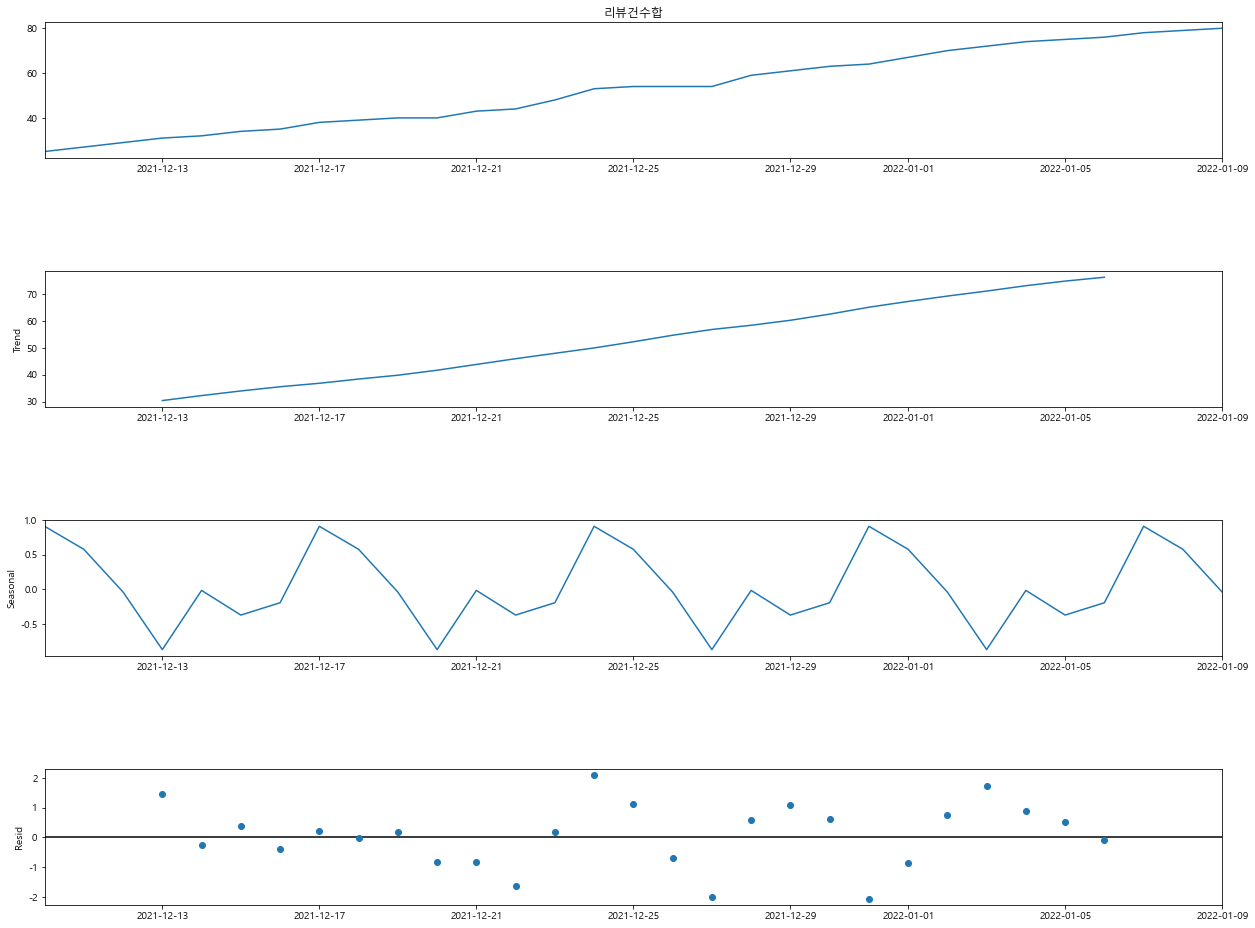

In [ ]:
result= seasonal_decompose(df1['리뷰건수합'],model='additive',period=7)

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,15)

# 꾸준히 증가하거나 꾸준히 감소하는 시계열데이터는 1차 차분으로 충분

# 1. 실제 관측값
# 2. 추세 : 지속적으로 증가하거나 감소하는 추세
# 3. 계절성 : 7-daily, 12-monthly, 52-weekly
# 4. 잔차

* ADF, pacf검정

C:\Users\2005-023\anaconda3\envs\python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


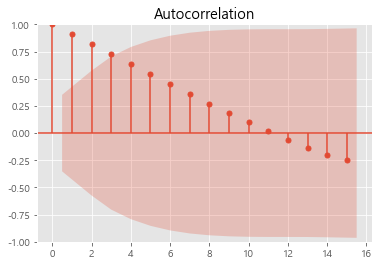

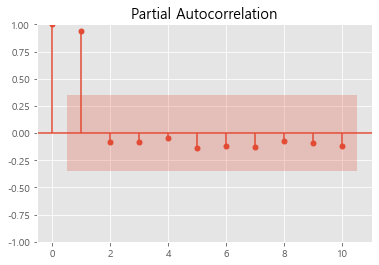

In [ ]:
plt.style.use('ggplot')

plot_acf(df1['리뷰건수합'])
plot_pacf(df1['리뷰건수합'], lags=10)
plt.show()

# 비정상 시계열데이터일 경우 ACF plot 이 천천히 감소함 

# Lag 현재 데이터에서 얼마나 쉬프트(시차) 했는지 0일 경우는 자신과의 상관 관계이므로 1
# ACF 가 일정한 패턴을 보이므로 비정상 시계열

In [ ]:
result = adfuller(df1['리뷰건수합'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))
    
# p-value 가 0.05 이하일 것

ADF Statistic: -0.3591440559965267
p-value: 0.9167000299530601
Critical Values:
	1%: -3.6699197407407405
	5%: -2.9640707407407407
	10%: -2.621171111111111


# 차분하기

- ARIMA 모델에선 대부분 1차분만 이용하고 최대 2차분을 주로 사용함 

C:\Users\2005-023\anaconda3\envs\python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


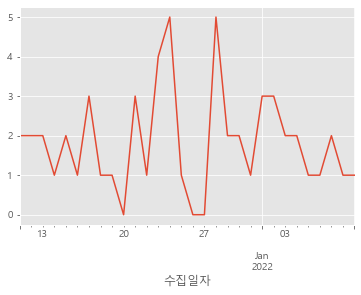

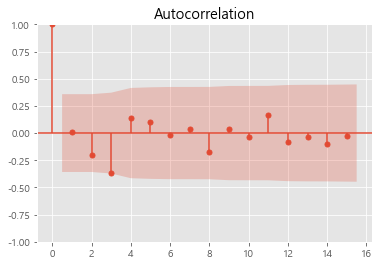

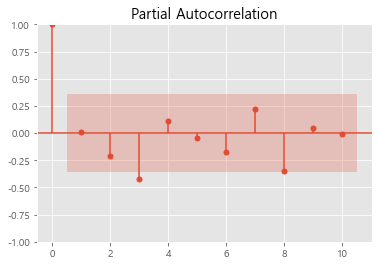

In [ ]:
plt.style.use('ggplot')

diff_1=df1['리뷰건수합'].diff(periods=1).iloc[1:]
diff_1.plot()
plot_acf(diff_1)
plot_pacf(diff_1, lags=10)
plt.show()

# ACF 가 일정한 패턴을 보이지 않으므로 정상 시계열

* 차분결과를 보니, 차이가 더욱 도드라져 보임
* 차분이후의 ACF 와 PACF 를 보니, 시계열이 정상상태를 보이는것으로 생각되므로, 1차차분만으로 충분할 것 같다.

In [ ]:
result = adfuller(diff_1)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))
    
# p-value 가 0.05 이하일 것

ADF Statistic: -4.670244126853538
p-value: 9.56776707943404e-05
Critical Values:
	1%: -3.6996079738860943
	5%: -2.9764303469999494
	10%: -2.627601001371742


# ARIMA 모델링

In [ ]:
train_data, test_data = train_test_split(df1,test_size=0.23,shuffle=False)
# train 77% test 23%

In [ ]:
from itertools import product

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score

### AIC score 를 사용한 최적화
ARMA 모형인 경우 모수 추정시 AIC/BIC 값을 이용하여 차수 결정 및 모수추정도 동시에 이루어 짐

- ACF/PACF 분석으로 AR(p) 모형 또는 MA(q) 모형 결정

- ACF가 특정 차수 이상에서 없어지는 경우(Cut-off)에는 MA 모형을 사용 가능

- PACF가 특정 차수 이상에서 없어지면 AR 모형을 사용 가능

- ACF와 PACF 모두 특정 차수 이상에서 없어지는 현상이 나타나지 않는다면 ARMA 모형을 사용

* Modeling 시계열 분석에 사용되는 ARIMA를 비롯해 크게 3가지가 있습니다. AR, MA, ARIMA 이 모델들을 결정짓는 데에는 parameter p, d, q를 설정이 중요한데요. 가령, parameter가 (p1, d1, q1,) 있다고 가정했을 때 q값이 0면 그 모델은 AR이고, p값이 0이라면 MA입니다. 그리고 예시처럼 p, d, q에 값이 전부 들어있다면 ARIMA model이 되는 것입니다. (parameter를 설정하고 tuning 하는 것은 다음 시간에 하겠습니다.!)
p, d, q에 어떤 값을 할당해서 어떤 모델을 만들지 모르겠을 때는 auto_arima library를 사용해 적합한 p,d,q값을 찾는데 도움을 받을 수 있습니다.

* ARIMA의 모수는 크게 3가지가 있다. AR모형의 Lag을 의미하는 p, MA모형의 Lag을 의미하는 q, 차분(Diffrence)횟수를 의미하는 d 가 그것이다. 보통은 p, d, q의 순서로 쓴다.
통상적으로 p + q < 2, p * q = 0 인 값들을 많이 사용한다.

* ACF그래프를 보면 10~12.5 timelag 를 기준으로 자기상관이 양에서 음으로 변동한다.
* PACF 그래프는 1의 timelag 에서 0.9 의 값을 가지고 이후에 급격히 감소한다. 따라서 p=0,q=1 이 적당하다고 추측 가능
* 적절한 차분 차수의 계산을 위해 우선 1차 차분을 하고, ACF 및 PACF 를 다시 계산한다.


# AUTO ARIMA

Modeling 시계열 분석에 사용되는 ARIMA를 비롯해 크게 3가지가 있습니다. AR, MA, ARIMA 이 모델들을 결정짓는 데에는 parameter p, d, q를 설정이 중요한데요. 가령, parameter가 (p1, d1, q1,) 있다고 가정했을 때 q값이 0면 그 모델은 AR이고, p값이 0이라면 MA입니다. 그리고 예시처럼 p, d, q에 값이 전부 들어있다면 ARIMA model이 되는 것입니다. (parameter를 설정하고 tuning 하는 것은 다음 시간에 하겠습니다.!) p, d, q에 어떤 값을 할당해서 어떤 모델을 만들지 모르겠을 때는 auto_arima library를 사용해 적합한 p,d,q값을 찾는데 도움을 받을 수 있습니다.

In [ ]:
from pmdarima.arima import auto_arima

model_auto_arima= auto_arima(train_data,trace=True,  start_p=1,start_q=1,max_p=3,max_q=3,
                             m=7,d=1,D=1,max_P=3,max_Q=3, 
                             error_action='ignore',
                             suppress_warnings=True, # 에러 관련
                             stepwise=False,
                             seasonal=True # 계절성 여부 T: SARIMA F: ARIMA02
                            )

 ARIMA(0,1,0)(0,1,0)[7]             : AIC=63.782, Time=0.01 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=64.304, Time=0.02 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,1,3)[7]             : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=64.597, Time=0.02 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(1,1,2)[7]             : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(1,1,3)[7]             : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=65.558, Time=0.04 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=67.558, Time=0.07 sec
 ARIMA(0,1,0)(2,1,2)[7]             : AIC=69.558, Time=0.06 sec
 ARIMA(0,1,0)(2,1,3)[7]             : AIC=71.558, Time=0.09 sec
 ARIMA(0,1,0)(3,1,0)[7]             : AIC=67.558, Time=0.07 sec
 ARIMA(0,1,0)(3,1,1)[7]             : AIC=69.558, Time=0.10 sec
 ARIMA(0,1,0)(3,1,2)[7]             : AIC=71.558, Time=0.11 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=65.782, Time=

In [ ]:
prediction_auto = model_auto_arima.predict(len(test_data),return_conf_int = True)
predicted_value_auto = prediction_auto[0]
predicted_ub_auto = prediction_auto[1][:,0]
predicted_lb_auto = prediction_auto[1][:,1]
predict_index_auto = list(test_data.index)
r2 = r2_score(test_data,predicted_value_auto)

In [ ]:
r2 = r2_score(test_data,predicted_value_auto)
rmse = mean_squared_error(test_data,predicted_value_auto, squared=False)
print(f'r2 : {r2} rmse : {rmse}')

r2 : 0.5119047619028563 rmse : 2.2638462845387735


In [ ]:
model_auto_arima.summary()
# 모델 요약
# AIC 가 낮을 수록 좋음

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   23
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 7)   Log Likelihood                 -30.891
Date:                           Thu, 20 Jan 2022   AIC                             63.782
Time:                                   13:42:27   BIC                             64.490
Sample:                                        0   HQIC                            63.775
                                            - 23                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         3.6000      1.661      2.168      0.030       0.345       6.855
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.49
Prob(Q):                              1.00   Prob(JB):                         0.78
Heteroskedasticity (H):               2.64   Skew:                            -0.23
Prob(H) (two-sided):                  0.31   Kurtosis:                         2.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# 모델 버젼 체크
statsmodels.__version__

'0.13.1'

#  Fbprophet

In [ ]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

Importing plotly failed. Interactive plots will not work.


In [ ]:
df = pd.read_csv('진짜최종.csv')

### 상품 아이디 변경

In [ ]:
df['수집일자']=df['수집일자'].str[:10].apply(lambda x: datetime.strptime(x,"%Y-%m-%d"))
df1 = df[df['상품아이디'] == pid ] ; 
df1.reset_index(inplace=True)

In [ ]:
df1 = df1[['수집일자','리뷰건수합']]
df1.columns = ['ds', 'y'] # 컬럼명이 반드시 ds y 여야만 동작함

In [ ]:
train = df1[:23] ;
test = df1[23:] ; train

,ds,y
0,2021-12-10,25
1,2021-12-11,27
2,2021-12-12,29
3,2021-12-13,31
4,2021-12-14,32
5,2021-12-15,34
6,2021-12-16,35
7,2021-12-17,38
8,2021-12-18,39
9,2021-12-19,40


In [ ]:
# 모델생성
m = Prophet()
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


In [ ]:
future = m.make_future_dataframe(periods = 9 ) # 앞으로 예측할 데이터프레임 먼저 생성

In [ ]:
fp_forecast = m.predict(future)
fp_forecast[['ds','yhat','yhat_lower','yhat_upper']].tail() #예측된 데이터 

,ds,yhat,yhat_lower,yhat_upper
27,2022-01-06,76.675009,75.404875,77.985042
28,2022-01-07,79.469254,78.236504,80.706205
29,2022-01-08,81.387818,80.133625,82.656176
30,2022-01-09,82.660629,81.314913,83.967849
31,2022-01-10,83.551871,82.111968,84.848156


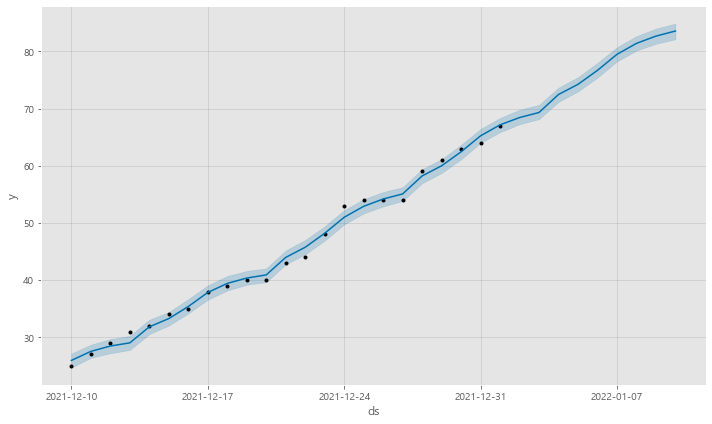

In [ ]:
fig1 = m.plot(fp_forecast)

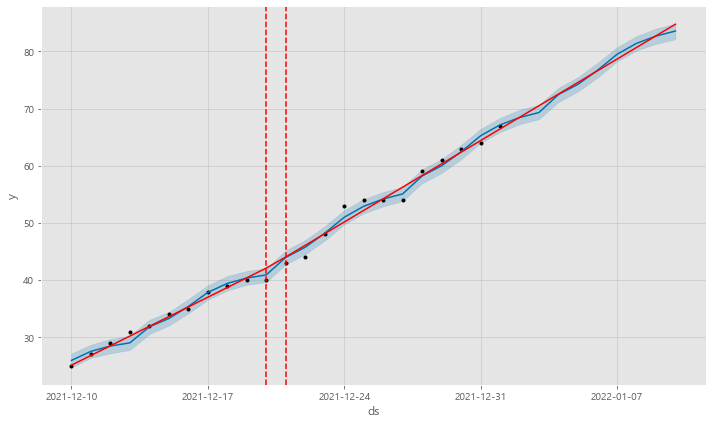

In [ ]:
fig1 = m.plot(fp_forecast)
a = add_changepoints_to_plot(fig1.gca(),m,fp_forecast) 
# 빨간 줄은 변화가 있는 체크포인트

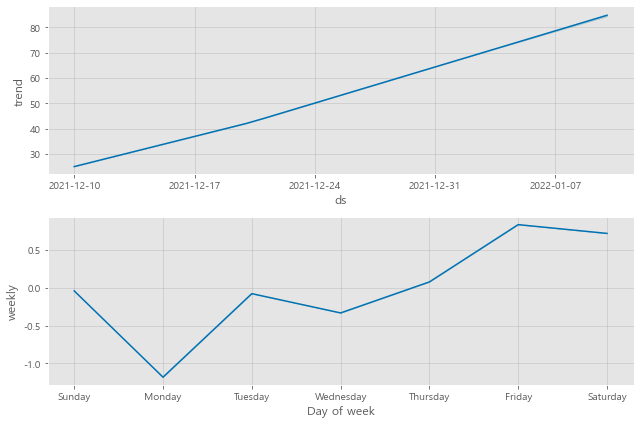

In [ ]:
fig2 = m.plot_components(fp_forecast) 
# 컴포넌트
# 주기성 확인?

In [ ]:
fp_pred_y = fp_forecast['yhat'].values[-9:]
# 진짜 결과
fp_test_y = test['y'].values

print(fp_pred_y)
print(fp_test_y)

[68.41698629 69.30822781 72.45004536 74.22927588 76.67500858 79.46925393
 81.38781801 82.66062924 83.55187076]
[70 72 74 75 76 78 79 80 81]


In [ ]:
r2 = r2_score(fp_test_y,fp_pred_y)
rmse = mean_squared_error(fp_test_y,fp_pred_y, squared=False)
print(f'r2 : {r2} rmse : {rmse}')

r2 : 0.6874803579429982 rmse : 1.9622820010174717


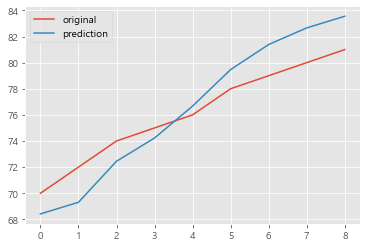

In [ ]:
plt.plot(fp_test_y, label = 'original')
plt.plot(fp_pred_y , label = 'prediction')
plt.legend()
plt.show()

# Seasonality, holiday effects., and regressor

In [ ]:
holidays =pd.DataFrame(columns=['ds','holiday']) #홀리데이 생성
holidays

,ds,holiday


In [ ]:
m = Prophet(
    holidays=holidays,
    holidays_prior_scale=2,
    weekly_seasonality=True,
    seasonality_mode='multiplicative',
    seasonality_prior_scale=10, # 얼마나 반영할건지
)
m.add_country_holidays(country_name='KR') # KR 대한민국 명절 
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


In [ ]:
m.train_holiday_names # 모델에 추가된 명절

0                                     New Year's Day
1          The day preceding of Lunar New Year's Day
2                               Lunar New Year's Day
3             The second day of Lunar New Year's Day
4                          Independence Movement Day
5                             Birthday of the Buddha
6                                     Children's Day
7                                         Labour Day
8                                       Memorial Day
9                                     Liberation Day
10             Alternative holiday of Liberation Day
11                      The day preceding of Chuseok
12                                           Chuseok
13                         The second day of Chuseok
14                           National Foundation Day
15    Alternative holiday of National Foundation Day
16                                       Hangeul Day
17                Alternative holiday of Hangeul Day
18                                     Christm

In [ ]:
h_future = m.make_future_dataframe(periods = 9 )
h_forecast = m.predict(h_future)
h_forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
27,2022-01-06,77.037858,75.875057,78.080957
28,2022-01-07,80.149795,78.924616,81.321459
29,2022-01-08,81.116226,79.893144,82.178157
30,2022-01-09,82.657439,81.536469,83.846661
31,2022-01-10,82.160451,80.945524,83.295568


C:\Users\2005-023\anaconda3\envs\python38\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\2005-023\anaconda3\envs\python38\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


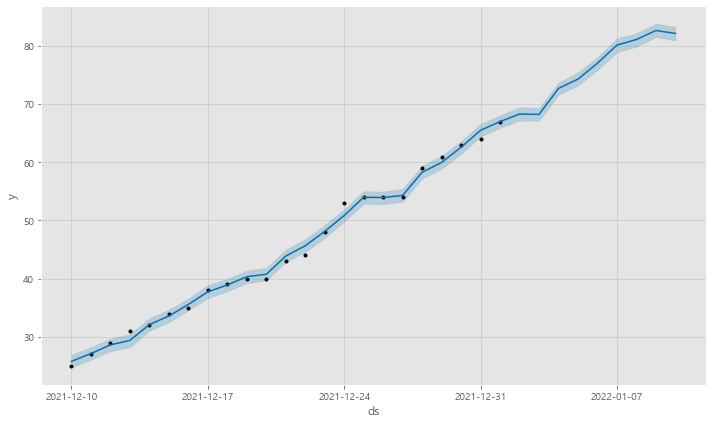

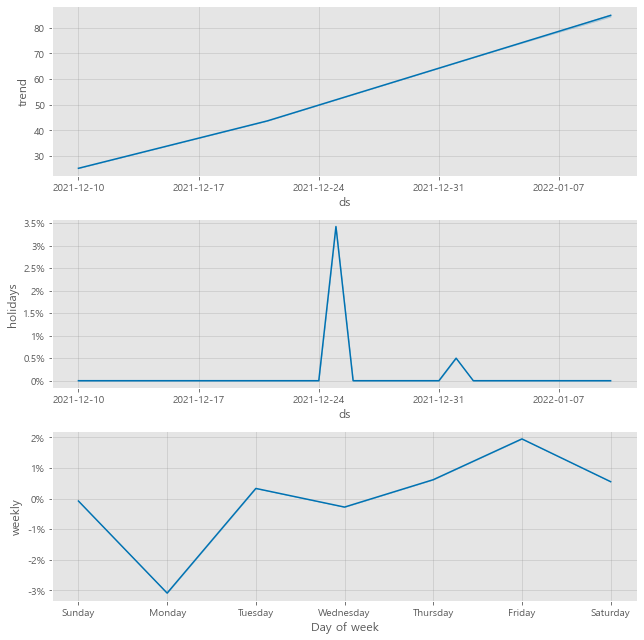

In [ ]:
fig1 = m.plot(h_forecast)
fig2 = m.plot_components(h_forecast)

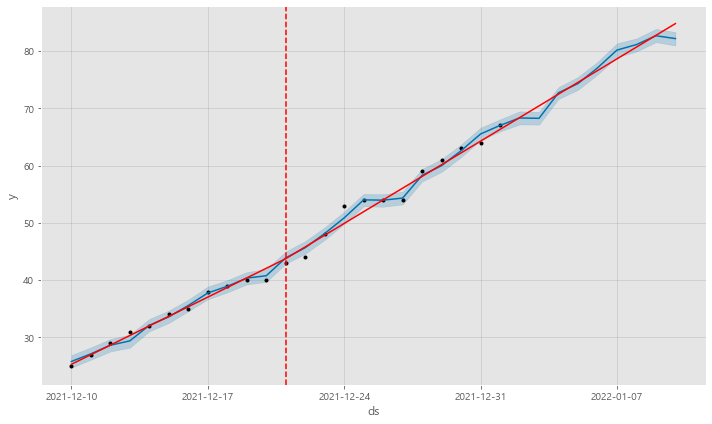

In [ ]:
fig1 = m.plot(h_forecast)
a = add_changepoints_to_plot(fig1.gca(),m,h_forecast)

In [ ]:
pred_y_holiday = h_forecast['yhat'].values[-9:]
# 진짜 결과
test_y_holiday = test['y'].values

print(pred_y_holiday)
print(test_y_holiday)

[68.30188922 68.23667445 72.70141379 74.30704797 77.03785764 80.14979521
 81.11622583 82.65743921 82.16045051]
[70 72 74 75 76 78 79 80 81]


In [ ]:
r2 = r2_score(test_y_holiday,pred_y_holiday)
rmse = mean_squared_error(test_y_holiday,pred_y_holiday, squared=False)
print(f'r2 : {r2} rmse : {rmse}')

r2 : 0.6591316159715759 rmse : 2.0493499338479406


C:\Users\2005-023\anaconda3\envs\python38\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


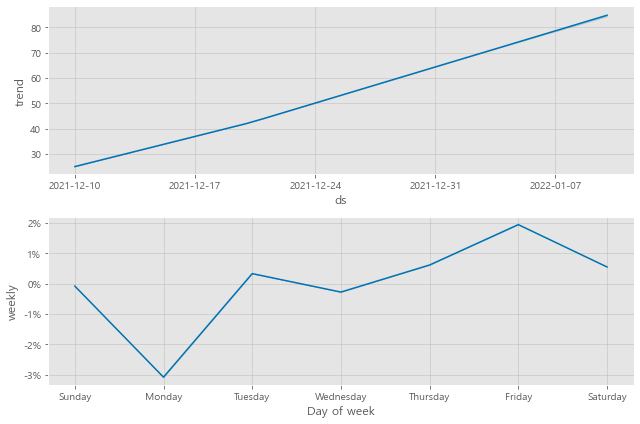

In [ ]:
fig2 = m.plot_components(fp_forecast)

In [ ]:
# from fbprophet.plot import plot_yearly
# m = Prophet(yeary_seasolnality=True).fit(train) #yearly_seasonality=1
# a = plot_yearly(m)

# MA

* sma (단순이동평균)

In [ ]:
df1['sma5'] = df1['y'].rolling(5).mean()
df1['sma20'] = df1['y'].rolling(20).mean()
df1['sma100'] = df1['y'].rolling(100).mean()
df1['sma200'] = df1['y'].rolling(200).mean()

In [ ]:
df1

,ds,y,sma5,sma20,sma100,sma200
0,2021-12-10,25,NaN,NaN,NaN,NaN
1,2021-12-11,27,NaN,NaN,NaN,NaN
2,2021-12-12,29,NaN,NaN,NaN,NaN
3,2021-12-13,31,NaN,NaN,NaN,NaN
4,2021-12-14,32,28.8,NaN,NaN,NaN
5,2021-12-15,34,30.6,NaN,NaN,NaN
6,2021-12-16,35,32.2,NaN,NaN,NaN
7,2021-12-17,38,34.0,NaN,NaN,NaN
8,2021-12-18,39,35.6,NaN,NaN,NaN
9,2021-12-19,40,37.2,NaN,NaN,NaN


* ema (지수이동평균)

In [ ]:
df1['ema5'] = df1['y'].ewm(5).mean()
df1['ema20'] = df1['y'].ewm(20).mean()
df1['ema100'] = df1['y'].ewm(100).mean()
df1['ema200'] = df1['y'].ewm(200).mean()

In [ ]:
plt.style.use('ggplot')

In [ ]:
# df1['리뷰건수합'].plot(figsize = (10,6))

In [ ]:
# df1['리뷰건수합'].rolling(window=5).mean().plot() 

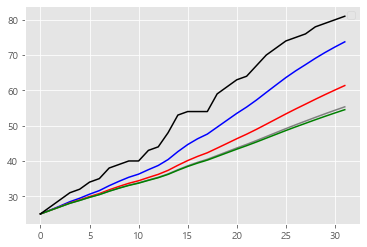

In [ ]:
plt.plot(df1['ema5'],color='blue')
plt.plot(df1['ema20'],color='red')
plt.plot(df1['ema100'],color='grey')
plt.plot(df1['ema200'],color='green')
plt.plot(df1['y'],color='black')
plt.legend()